In [152]:
# Import modules
import os
import sys
sys.path.append(r'..\Hardware_src') # Make the change according to your path

# Python modules for figure visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io
from scipy import signal
import math
import cv2
import screeninfo
from scipy.linalg import hadamard    
from scipy.optimize import minimize
from pathlib import Path
import random
from scipy import fft

## M = N

### 1D Identity Reconstruction

In [2]:
# Load data
file_path = Path(os.getcwd())
data_path = file_path.joinpath('C:/Users/russe/OneDrive - Johns Hopkins/imaging instrumentation/FinalProj')

black_subtract_1d = np.loadtxt(data_path.joinpath('black_subtract_1d_59.csv'), delimiter=',')
black_subtract_1d = black_subtract_1d.reshape(1024,1280,16)
mask1d = np.loadtxt(data_path.joinpath('mask_1d_59.csv'), delimiter=',')
mask1d = mask1d.reshape(16,16,16)
scene_1d = np.loadtxt(data_path.joinpath('scene_1d_59.csv'), delimiter=',')
scene_1d = scene_1d.reshape(1024,1280,16)

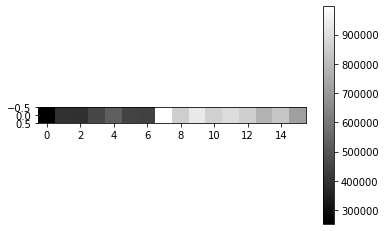

In [3]:
# Create Y and A matrix
# Subtract ambient lighting
# row in scence image, 500 - 545,
# column in scene image, 269 - 1021, 47 for each pattern
black_corrected = np.zeros([1024,1280])
Y = np.zeros([16,1])
A_1d_id = np.identity(16)
Y_1d_id = np.zeros([16,1])

for i in range(16):
    # subtract ambient lighting
    black_corrected[:,:] = scene_1d[:,:,i] - black_subtract_1d[:,:,i]
    Y_1d_id[i,0] = np.sum(black_corrected[500:545,269:1021])

A_inv_1d_id = np.linalg.pinv(A_1d_id, rcond=1e-1)
X_1d_id = np.matmul(A_inv_1d_id, Y_1d_id)
plt.imshow(np.transpose(X_1d_id), cmap='gray')
plt.colorbar()
plt.show()


### 1D Random Reconstruction

In [4]:
# Load data
black_subtract_1drand = np.loadtxt(data_path.joinpath('black_subtract_1drand_59.csv'), delimiter=',')
black_subtract_1drand = black_subtract_1drand.reshape(1024,1280,16)
mask1drand = np.loadtxt(data_path.joinpath('mask_1drand_59.csv'), delimiter=',')
mask1drand = mask1drand.reshape(16,16,16)
scene_1drand = np.loadtxt(data_path.joinpath('scene_1drand_59.csv'), delimiter=',')
scene_1drand = scene_1drand.reshape(1024,1280,16)

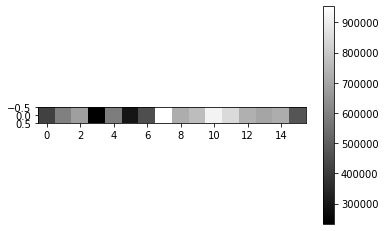

In [5]:
# Create Y and A matrix
# Subtract ambient lighting
# row in scence image, 500 - 545,
# column in scene image, 269 - 1021, 47 for each pattern
black_corrected = np.zeros([1024,1280])
Y = np.zeros([16,1])
A_1d_rand = np.zeros([16,16])
Y_1d_rand = np.zeros([16,1])

for i in range(16):
    # subtract ambient lighting
    black_corrected[:,:] = scene_1drand[:,:,i] - black_subtract_1drand[:,:,i]
    Y_1d_rand[i,0] = np.sum(black_corrected[500:545,269:1021])
    A_1d_rand[i,:] = mask1drand[8,:,i]

A_inv_1d_rand = np.linalg.pinv(A_1d_rand, rcond=1e-1)
X_1d_rand = np.matmul(A_inv_1d_rand, Y_1d_rand)
plt.imshow(np.transpose(X_1d_rand), cmap='gray')
plt.colorbar()
plt.show()


### 2D Identity Reconstruction

In [11]:
# Load data
data_path = file_path.joinpath('C:/Users/russe/OneDrive - Johns Hopkins/FinalProj')

black_subtract_2d = np.loadtxt(data_path.joinpath('blackimg2_59.csv'), delimiter=',')
black_subtract_2d = black_subtract_2d.reshape(1024,1280)
mask2d = np.loadtxt(data_path.joinpath('mask_2d_59.csv'), delimiter=',')
mask2d = mask2d.reshape(16,16,256)
scene_2d = np.loadtxt(data_path.joinpath('scene_2d_59.csv'), delimiter=',')
scene_2d = scene_2d.reshape(1024,1280,256)

In [11]:
# Load Data
data_path = file_path.joinpath('C:/Users/russe/OneDrive - Johns Hopkins/FinalProj')
Y_2d_id = np.loadtxt(data_path.joinpath('Y_2d_id.csv'), delimiter=',')
A_2d_id = np.loadtxt(data_path.joinpath('A_2d_id.csv'), delimiter=',')


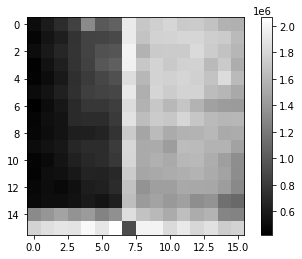

In [14]:
A_inv_2d_id = np.linalg.pinv(A_2d_id, rcond=1e-1)
X_2d_id = np.matmul(A_inv_2d_id, Y_2d_id)
X_2d_id = X_2d_id.reshape(16,16)

plt.imshow(X_2d_id, cmap='gray')
plt.colorbar()
plt.show()


### 2D Random Reconstruction

In [22]:
# Load data
data_path = file_path.joinpath('C:/Users/russe/OneDrive - Johns Hopkins/FinalProj')
scene_2drand_crop = np.loadtxt(data_path.joinpath('scene_2drand_crop.csv'), delimiter=',')
scene_2drand_crop = scene_2drand_crop.reshape(800,850,256)
A_2drand = np.loadtxt(data_path.joinpath('A_2d_rand.csv'), delimiter=',')
black_subtract_2drand = np.loadtxt(data_path.joinpath('blackimg_510.csv'), delimiter=',')


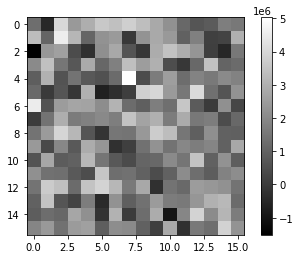

In [98]:
Y_2drand = np.zeros([256,1])
for i in range(256):
    Y_2drand[i,0] = np.sum(scene_2drand_crop[:,:,i] - black_subtract_2drand[100:900,200:1050])

A_inv_2drand = np.linalg.pinv(A_2drand, rcond=1e-1)
X_2drand = np.matmul(A_inv_2drand, Y_2drand)
X_2drand = X_2drand.reshape(16,16)

plt.imshow(X_2drand, cmap='gray')
plt.colorbar()
plt.show()


## M << N

### 2D Identity Reconstruction

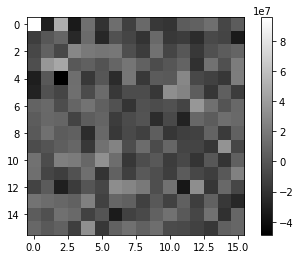

In [150]:
# Generate sparse matrices
M = 64 # 25% of original data
N = 256
sparse_ind = random.sample(range(N),M)

sparse_Y_id = Y_2d_id[sparse_ind]
sparse_A_id = A_2d_id[sparse_ind]

# Calculate Theta
Phi  = sparse_A_id
Theta = np.zeros([M,N])
mat = np.identity(N)
for i in range(256):
    psi = scipy.fft.idctn(mat[i,:], type=2)
    psi = np.transpose(psi.reshape(N))
    Theta[:,i] = Phi@psi

# Compressed Sensing Alg 1
# Solve y = A*x for x using L1 minimum norm solution
def L1_norm(x):
    return np.linalg.norm(x, ord=1)

# Set constraints for optimization
constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - sparse_Y_id})

# Initialize minimization with L2 solution
x0 = np.linalg.pinv(Theta) @ sparse_Y_id
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
x_L1 = res.x
x_L1 = x_L1.reshape(16,16)
x0 = x0.reshape(16,16)

plt.imshow(x_L1, cmap='gray')
plt.colorbar()
plt.show()


### 2D Random Speckle Reconstruction

In [151]:
# Generate sparse matrices
M = 64
N = 256
sparse_ind = random.sample(range(N),M)

sparse_Yrand = Y_2drand[sparse_ind]
sparse_Arand = A_2drand[sparse_ind]

Phi  = sparse_Arand
Theta = np.zeros([M,N])
mat = np.identity(N)
for i in range(256):
    psi = scipy.fft.idctn(mat[i,:], type=2)
    psi = np.transpose(psi.reshape(N))
    Theta[:,i] = Phi@psi

# Compressed Sensing Alg 1
# Solve y = A*x for x using L1 minimum norm solution
def L1_norm(x):
    return np.linalg.norm(x, ord=1)

# Set constraints for optimization
constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - sparse_Yrand})

# initialize minimization with L2 solution
x0 = np.linalg.pinv(Theta) @ sparse_Yrand
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
x_L1 = res.x
x_L1 = x_L1.reshape(16,16)

plt.imshow(x_L1, cmap='gray')
plt.colorbar()
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)